In [1]:
import pandas as pd
import numpy as np


from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
stop_words = list(ENGLISH_STOP_WORDS)

import pprint
import re
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
df= pd.read_csv('fake_or_real_news.csv', index_col=0)
kaggle= pd.read_csv('fake.csv')

In [ ]:
df.shape, kaggle.shape

In [ ]:
#Cleaning for analysis

In [ ]:
kaggle.sample(3)

In [4]:
kaggle['type'].value_counts().unique

<bound method Series.unique of bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: type, dtype: int64>

In [5]:
kaggle["label"]=kaggle["type"]
kaggle=kaggle.drop('type', axis=1)

In [6]:
le1 = LabelEncoder()
kaggle['numerical_label']=le1.fit_transform(kaggle['label'])
kaggle = kaggle.reset_index(drop=True)

In [ ]:
kaggle.sample(3)

In [ ]:
df.sample(7)

In [ ]:
df['label'].value_counts().unique

In [7]:
le2 = LabelEncoder()
df['binary_label']=le2.fit_transform(df['label'])
df = df.reset_index(drop=True)

In [8]:
def cleaner(text):
    try:
        text = re.sub('[.,\/#!$%\^&\*;:{}\+=<>_`~()]', ' ', text)
        text = re.sub('[^a-z0-9 ]','', text.lower())
#         text = re.sub('displaystyle',' ', text)
        text = re.sub('\s+',' ',text)
    except: 
        pass
    return text

In [9]:
df["text"]=df["text"].apply(cleaner)

In [10]:
df.sample(7)

,title,text,label,binary_label
1149,Identity of ISIS terrorist known as 'Jihadi Jo...,the true identity of the isis terrorist known ...,REAL,1
3156,"Poll: Voters trust Trump on economy, Clinton o...",voters say the top issues facing the country a...,REAL,1
2889,Tom Cotton calls for ‘global military dominanc...,over the course of just a few days last week t...,REAL,1
4291,Koch Brothers Helped Incite the Impending Bloo...,by rmuse 7 57 pm if the party doesnt learn les...,FAKE,0
6302,"Hillary Clinton, FBI and the Real November Sur...",by wmw admin on november 6 2016 pepe escobar s...,FAKE,0
4406,'Massive' French airstrikes hit Islamic State ...,frances military launched massive retaliatory ...,REAL,1
3992,“He and I Haven’t Spoken”: Trump and Pence Are...,in the middle of a heated exchange about the s...,REAL,1


### Ideas to drive from EDA:
* Look at global token counts
  * Ngrams (individually 2,3,4,5,6.  Then Range 2,6)
* Look at subsets for labels (+ ngrams)
* Look at New datasets (kaggle)
* Look at specific time periods (do some research first)
* Look at what is distinct between classes / labels
* Make this modular (consider OO python)
  * Swap out vectorizers
* Start plotting everything

In [ ]:

# stop_words.extend(["number", "like", "just"]) #after round one
# stop_words.extend(["donald","trump", "hillary", "clinton", "obama", "number", "like"])
#"united", "states", "white", "house"

In [ ]:
my_stops=["donald","trump", "clinton", "obama", "number", "like", "number", "like", "just"]


In [11]:
class TokenAnalysis(object):
    from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
    from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
    
    
    def __init__(self, df, Vectorizer=None, max_df=None, n_gram_range=None, stop_words=None):
        self.text=df["text"]
        self.label=df["label"]
        
        self.max_df=max_df
        self.ngram_range= n_gram_range
        self.vec=Vectorizer
#         self.vectorizer=self.init_vectorizer(sel.vec)
        
        if stop_words is None:
            self.stop_words=list(ENGLISH_STOP_WORDS)           
        else:
            self.stop_words= stop_words
        
        
        if self.vec is None:
            if self.max_df is None:
                self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=0.7) 
            else:
                self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=self.max_df)
                
        else:                    
            if self.ngram_range is None:
                self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7)
            else:
                self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7, ngram_range=self.ngram_range)
        

        
    
        # make token dataframe called X_text
        self.X = self.vectorizer.fit_transform(self.text)
        self.X_text = pd.DataFrame(self.X.toarray(), columns = self.vectorizer.get_feature_names())
        self.X_text.index=self.label
    
    #intialize vectorizer
#     def init_vectorizer(self, vec):   
         
#         #default to CountVectorizer

#         if self.vec is None:
#             if self.max_df is None:
#                 self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=0.7) 
#             else:
#                 self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=self.max_df)
                
#         else:                    
#             if self.ngram_range is None:
#                 self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7)
#             else:
#                 self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7, ngram_range=self.ngram_range)
                
        
    def top_tokens(self, num=None, label=None):
        
        if num is None and label is None:
            token_sum = self.X_text.sum()
            top=token_sum.sort_values(ascending=False)
            return top[:10]
        
        if label is None:
            token_sum = self.X_text.sum()
            top=token_sum.sort_values(ascending=False)
            return top[:num]
        
        else:
            token_sums_labeled = self.X_text[self.X_text.index==label].sum()
            top=token_sums_labeled.sort_values(ascending=False)
            
            if num is None:
                return top[:10]
            else:
                return top[:num] 
            
            
            
    def top_tokens_label_freq(self, num=None):
        if num is None:
            num=10
            
        top=self.top_tokens(num)
        return self.X_text.groupby(self.X_text.index)[top.index[:num]].sum()                                                      

    
    def plot_top_tokens(self, num=None, label=None):
        top=self.top_tokens(num, label)
     
        if label is None:
            label="GLOBAL"
        
        plt.figure(figsize=(8,6))
        
        plot1=sns.barplot(x=top.index, y=top)
        
        plot1.set_title("Top {} {} tokens".format(len(top), label))
        plot1.set_xticklabels(top.index, rotation=30)
        plt.show()
        
        
        
    def plot_top_tokens_by_binary_label(self, num=None):
        #set scale by axis
        labeled_df=self.top_tokens_label_freq(num).T
        labels=list(labeled_df.columns)
        ylim=max(max(self.top_tokens(label=labels[0])), max(self.top_tokens(label=labels[1])))
        
        fig, ax = plt.subplots(1, len(labels), figsize=(15, 8))

        for axes in range(len(labels)):
            label=labels[axes]
            plot=labeled_df[label].plot(kind="bar", ax=ax[axes])
            plot.set_xticklabels(labeled_df.index, rotation=30)
            ax[axes].set_title("Freq of top tokens in {} Articles".format(label))
            ax[axes].set_ylim([0,ylim*1.10])
        
        plt.show()
        
        
    
    def plot_top_tokens_by_label(self, num=None):
        labeled_df=self.top_tokens_label_freq(num).T
        labels=list(labeled_df.columns)
        ylim=0
        
        for i in range(len(labels)):
            if labels[i] != "bs":
                ylim= max(ylim, max(self.top_tokens(label=labels[i])))
        
        fig, ax = plt.subplots(len(labels), 1, figsize=(10, 75))

        for axes in range(len(labels)):
            label=labels[axes]
            plot=labeled_df[label].plot(kind="bar", ax=ax[axes])
            plot.set_xticklabels(labeled_df.index, rotation=30)
            ax[axes].set_title("Freq of top tokens in {} Articles".format(label))
            if label!="bs":
                ax[axes].set_ylim([0,ylim*1.10])

        
        plt.show()
        
        
        
    def add_stops(self, words):
        if type(words) is list:
            self.stop_words.extend(words)
        else:
            self.stop_words.append(words)
        

        if self.vec is None:
            if self.max_df is None:
                self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=0.7) 
            else:
                self.vectorizer=CountVectorizer(stop_words=self.stop_words, max_df=self.max_df)
                
        else:                    
            if self.ngram_range is None:
                self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7)
            else:
                self.vectorizer=self.vec(stop_words=self.stop_words, max_df=0.7, ngram_range=self.ngram_range)
        
        
        self.X = self.vectorizer.fit_transform(self.text)
        self.X_text = pd.DataFrame(self.X.toarray(), columns = self.vectorizer.get_feature_names())
        self.X_text.index=self.label
        
        
        
        

In [ ]:
#EDA using TokenAnalysis Classclass

In [ ]:
#1 Smaller dataset df only FAKE and REAL labels

In [12]:
sub=df.sample(1000)

In [ ]:
#Instansiate Analysis object with Countvectorizer
CV_1 = TokenAnalysis(sub)

In [ ]:
#Instansiate Analysis object with TfidfVectorizer of varying ngram_ranges

In [ ]:
TF_1_ngram = TokenAnalysis(sub, TfidfVectorizer)
TF_2_ngram = TokenAnalysis(sub, TfidfVectorizer, n_gram_range=(2,2))
TF_3_ngram = TokenAnalysis(sub, TfidfVectorizer, n_gram_range=(3,3))
TF_4_ngram = TokenAnalysis(sub, TfidfVectorizer, n_gram_range=(4,4))
TF_5_ngram = TokenAnalysis(sub, TfidfVectorizer, n_gram_range=(5,5))
TF_6_ngram = TokenAnalysis(sub, TfidfVectorizer, n_gram_range=(6,6))

In [ ]:
# Top 10 GLOBAL tokens
CV_1.plot_top_tokens()

# Top 10 GLOBAL tokens for each label
CV_1.plot_top_tokens_by_binary_label()

# Top 10 FAKE tokens
CV_1.plot_top_tokens(label="FAKE")

# Top 10 REAL tokens
CV_1.plot_top_tokens(label="REAL")



In [ ]:
# Top 10 GLOBAL tokens
TF_1_ngram.plot_top_tokens()

# Top 10 GLOBAL tokens for each label
TF_1_ngram.plot_top_tokens_by_binary_label()

# Top 10 FAKE tokens
TF_1_ngram.plot_top_tokens(label="FAKE")

# Top 10 REAL tokens
TF_1_ngram.plot_top_tokens(label="REAL")

In [ ]:
# Top 10 GLOBAL tokens
TF_2_ngram.plot_top_tokens()

# Top 10 GLOBAL tokens for each label
TF_2_ngram.plot_top_tokens_by_binary_label()

# Top 10 FAKE tokens
TF_2_ngram.plot_top_tokens(label="FAKE")

# Top 10 REAL tokens
TF_2_ngram.plot_top_tokens(label="REAL")

In [ ]:
# Top 10 GLOBAL tokens
TF_3_ngram.plot_top_tokens()

# Top 10 GLOBAL tokens for each label
TF_3_ngram.plot_top_tokens_by_binary_label()

# Top 10 FAKE tokens
TF_3_ngram.plot_top_tokens(label="FAKE")

# Top 10 REAL tokens
TF_3_ngram.plot_top_tokens(label="REAL")



In [ ]:
####kaggle token analysis

In [13]:
kaggle['label'].value_counts().unique

<bound method Series.unique of bs            11492
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
fake             19
Name: label, dtype: int64>

In [14]:
kaggle['text'].isnull().sum()

46

In [15]:
def get_date(date):
    date=date[:10]
    date=datetime.strptime(date, '%Y-%m-%d')
    
    return date
    

In [16]:
kaggle["date"] = kaggle['published'].apply(get_date)
kaggle["date"] = pd.to_datetime(kaggle["date"])
kaggle["month"] = kaggle["date"].dt.month
kaggle["day"] = kaggle["date"].dt.day
kaggle["year"] = kaggle["date"].dt.year

In [17]:
#clean text
kaggle["text"]=kaggle["text"].apply(cleaner)
kaggle["text"] = kaggle["text"].fillna('')

In [18]:
#add fake to bs
kaggle.loc[kaggle['label'] == "fake", 'label'] = "bs"

In [19]:
kaggle['label'].value_counts().unique

<bound method Series.unique of bs            11511
bias            443
conspiracy      430
hate            246
satire          146
state           121
junksci         102
Name: label, dtype: int64>

<bound method Series.unique of bs            11511
bias            443
conspiracy      430
satire          146
Name: label, dtype: int64>

In [ ]:
kag_sub=kaggle.sample(1000)

In [ ]:
print("Date Range: ", (str(min(kaggle["date"])), max(kaggle["date"])))

In [ ]:
social_reach_cols=["replies_count", 'participants_count', 'likes', 'comments','shares']
feature_engineer_df=kaggle[social_reach_cols]

feature_engineer_df.head()

In [ ]:
scaler=MinMaxScaler()
for col in feature_engineer_df.columns:
    x_scaled = scaler.fit_transform(feature_engineer_df[social_reach_cols])
    feature_engineer_df[col]=x_scaled


kaggle["social_reach_score"]=feature_engineer_df[social_reach_cols[0]] + feature_engineer_df[social_reach_cols[1]] \
                        + feature_engineer_df[social_reach_cols[2]]  + feature_engineer_df[social_reach_cols[3]] \
                        + feature_engineer_df[social_reach_cols[4]] 
kaggle.sample(3)

In [38]:
#Dataframes to model


#1 4 distinct labels
kaggle=kaggle[(kaggle["label"]=="bs")\
       | (kaggle["label"]=="bias") \
       | (kaggle["label"]=="conspiracy") \
       | (kaggle["label"]=="satire")]


#2 Important date ranges between 10-25 and 11-25
before_comey_mask=kaggle["date"]<'2016-10-28 00:00:00'
comey_mask=(kaggle["date"]>='2016-10-28 00:00:00' )& (kaggle["date"]<='2016-11-07 00:00:00')
election_mask=(kaggle["date"]>='2016-11-08 00:00:00' )& (kaggle["date"]<='2016-11-10 00:00:00')
after_election_mask=kaggle["date"]>='2016-11-10 00:00:00' 

bc_df = kaggle[before_comey_mask]
comey_df = kaggle[comey_mask]
election_df = kaggle[election_mask]
ae_df = kaggle[after_election_mask]






In [39]:
CV_bc = TokenAnalysis(bc_df)
TF_1_ngram_bc = TokenAnalysis(bc_df, TfidfVectorizer)
TF_2_ngram_bc = TokenAnalysis(bc_df, TfidfVectorizer, n_gram_range=(2,2))
TF_3_ngram_bc = TokenAnalysis(bc_df, TfidfVectorizer, n_gram_range=(3,3))


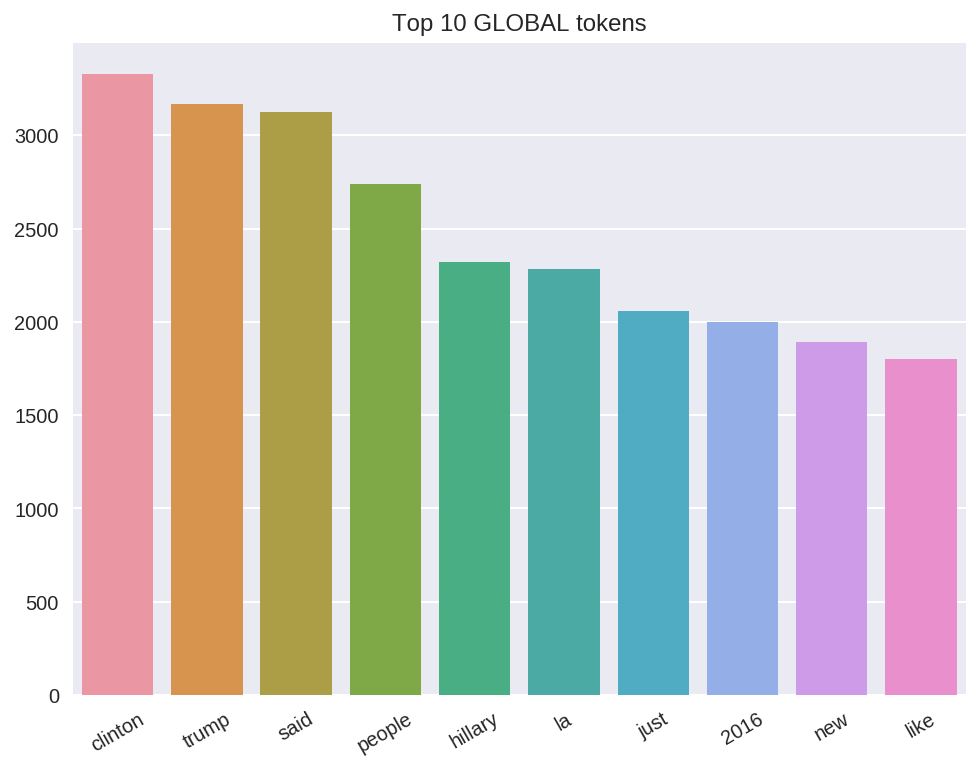

In [40]:
# Top 10 GLOBAL tokens
CV_bc.plot_top_tokens()

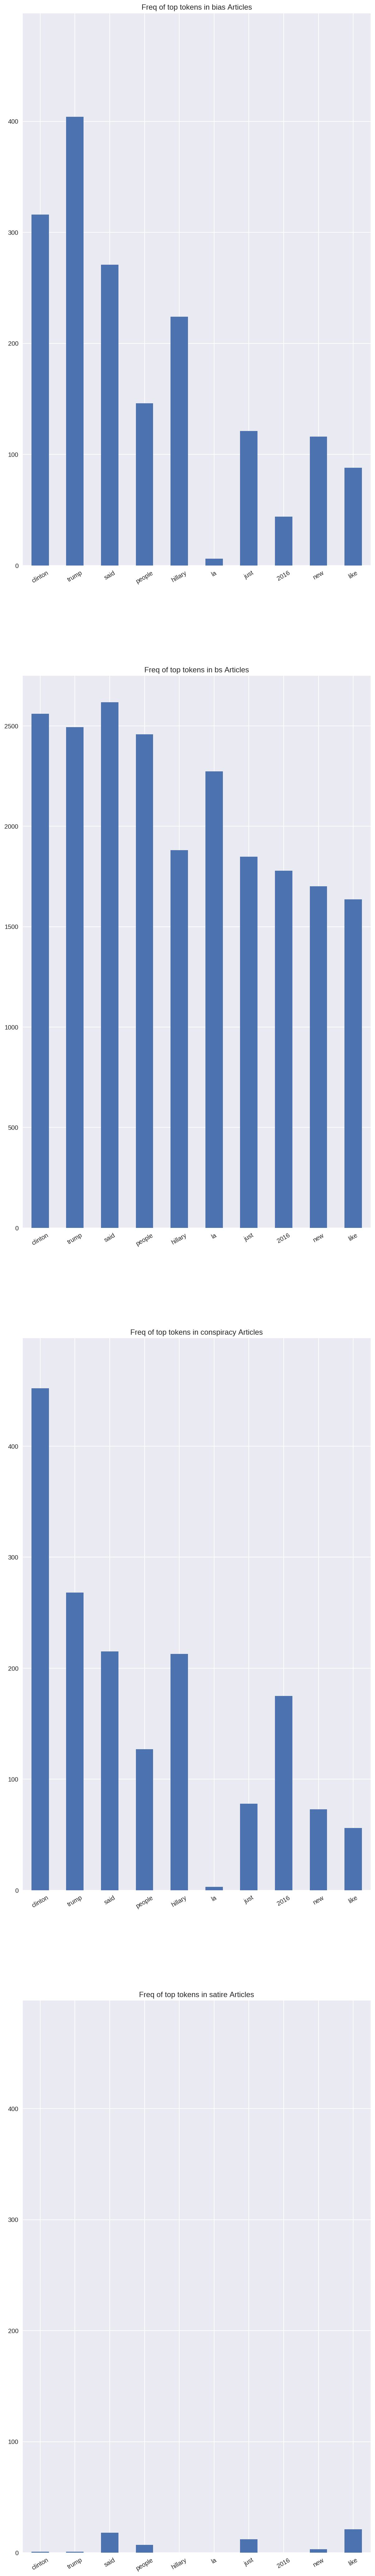

In [41]:
# Top 10 GLOBAL tokens for each label

CV_bc.plot_top_tokens_by_label()

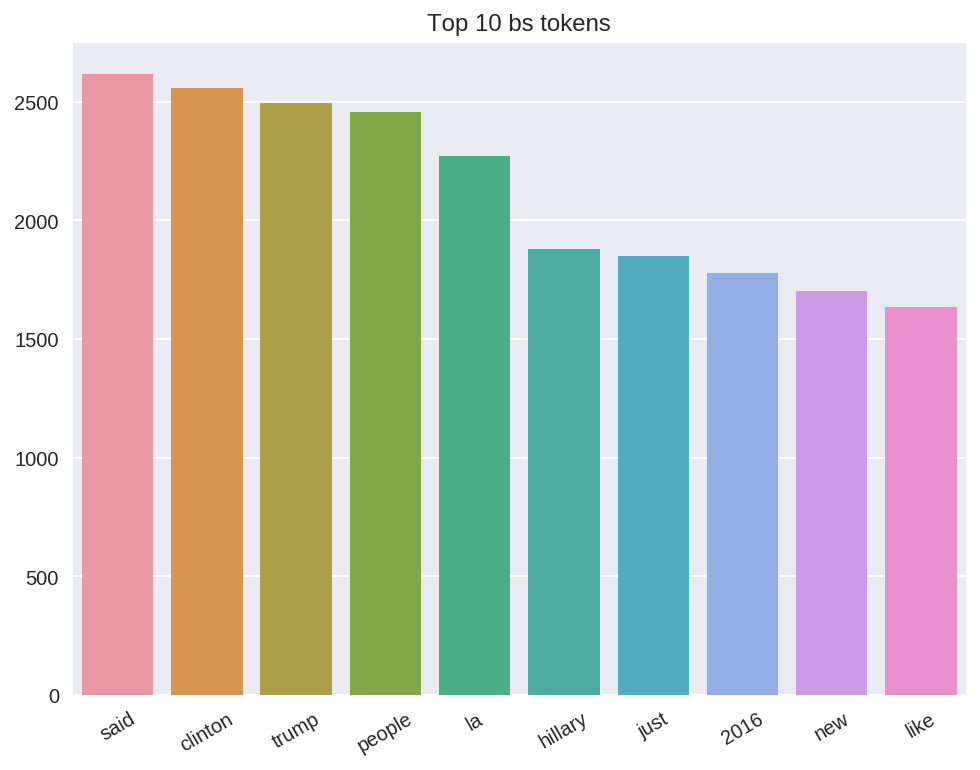

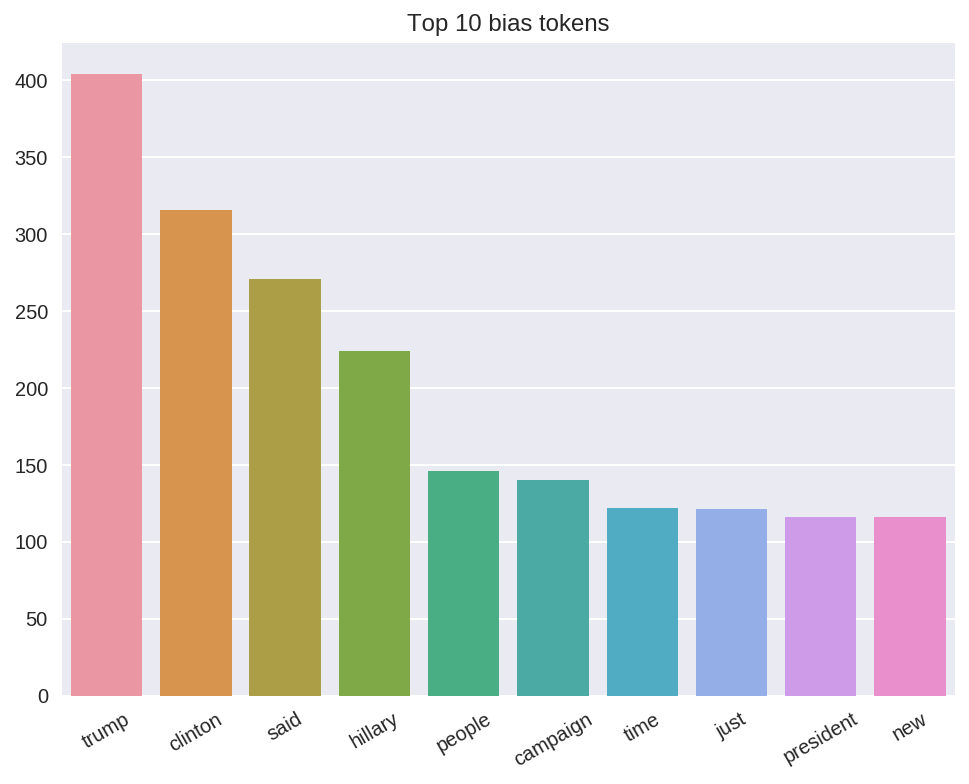

In [42]:
# Top 10 bs tokens
CV_bc.plot_top_tokens(label="bs")

# Top 10 bias tokens
CV_bc.plot_top_tokens(label="bias")

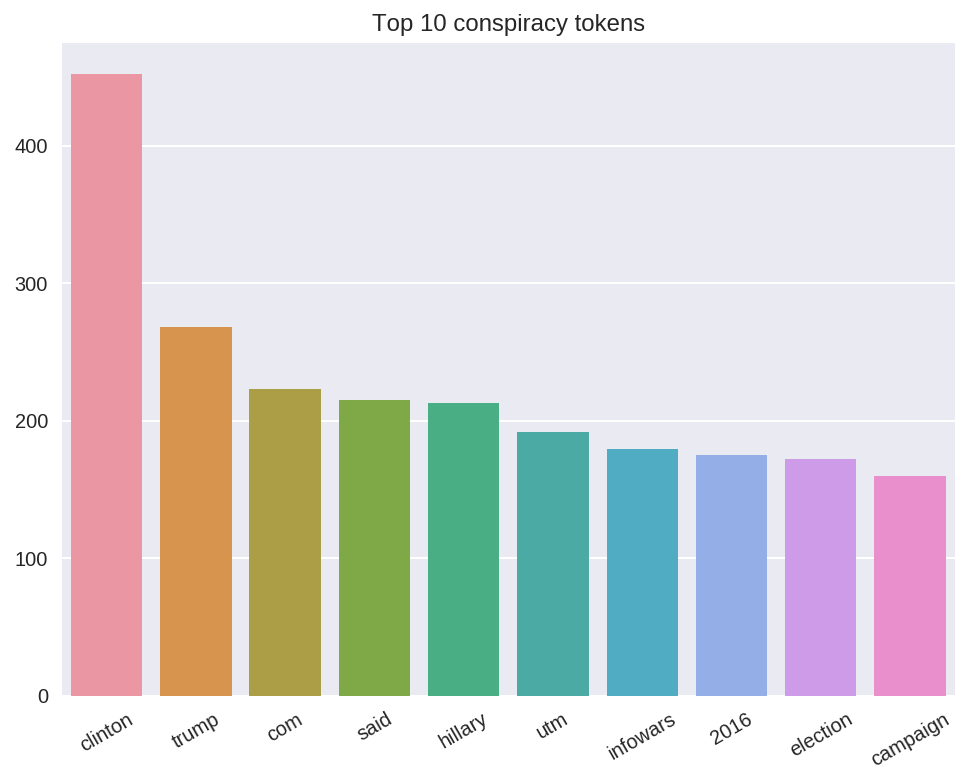

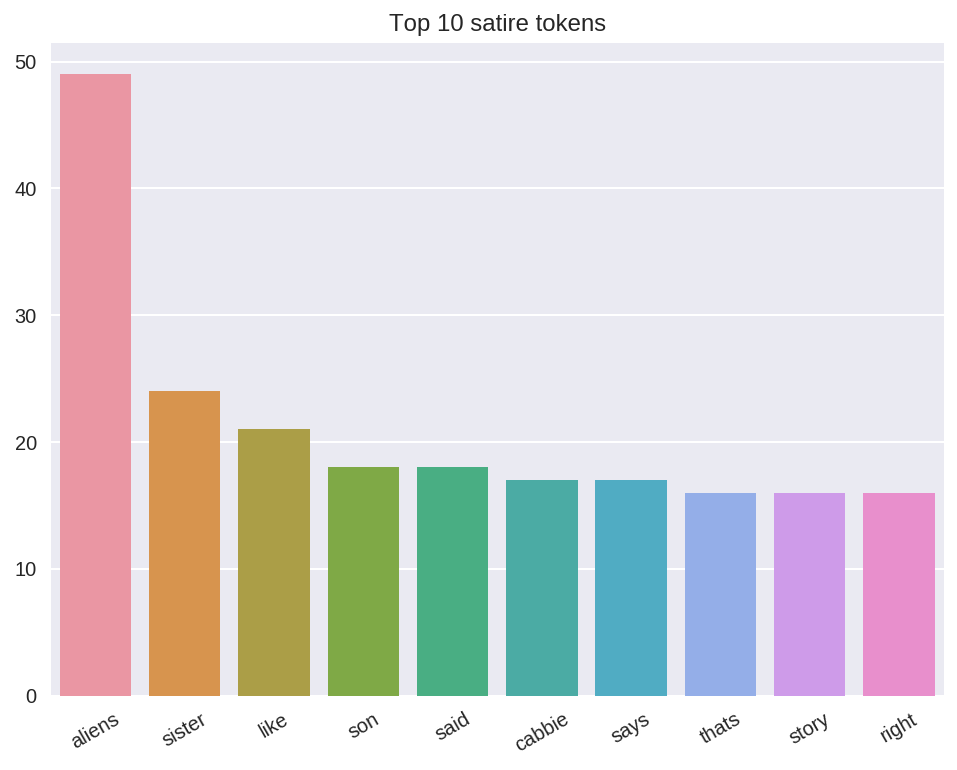

In [43]:
# Top 10 conspiracy tokens
CV_bc.plot_top_tokens(label="conspiracy")

# Top 10 satire tokens
CV_bc.plot_top_tokens(label="satire")

In [ ]:
# Top 10 GLOBAL tokens
TF_2_ngram_bc.plot_top_tokens()

# Top 10 GLOBAL tokens for each label
TF_2_ngram_bc.plot_top_tokens_by_label()

In [ ]:
# Top 10 bs tokens
TF_2_ngram_bc.plot_top_tokens(label="bs")

# Top 10 bias tokens
TF_2_ngram_bc.plot_top_tokens(label="bias")

In [ ]:
# Top 10 conspiracy tokens
TF_2_ngram_bc.plot_top_tokens(label="conspiracy")

# Top 10 satire tokens
TF_2_ngram_bc.plot_top_tokens(label="satire")

In [ ]:
# Top 10 GLOBAL tokens
TF_3_ngram_bc.plot_top_tokens()

# Top 10 GLOBAL tokens for each label
TF_3_ngram_bc.plot_top_tokens_by_label()

In [ ]:
# Top 10 bs tokens
TF_3_ngram_bc.plot_top_tokens(label="bs")

# Top 10 bias tokens
TF_3_ngram_bc.plot_top_tokens(label="bias")

In [ ]:
# Top 10 conspiracy tokens
TF_3_ngram_bc.plot_top_tokens(label="conspiracy")

# Top 10 satire tokens
TF_3_ngram_bc.plot_top_tokens(label="satire")

In [ ]:
# Initialize the `tfidf_vectorizer`  with n_gram range 2,6
tfidf_vectorizer2 = TfidfVectorizer(stop_words=stop_words, max_df=0.7, ngram_range=(2,2)) 

# Fit and transform the training data 
tfidf_train2 = tfidf_vectorizer2.fit_transform(X_train) 

# Transform the test set 
tfidf_test2 = tfidf_vectorizer2.transform(X_test)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

In [ ]:
clf = MultinomialNB()

clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

In [ ]:
clf = MultinomialNB()

clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)